# Working with Chandra FITS tables

## Authors
Lia Corrales, Kris Stern, Lúthien  Liu, Zihao Chen, Saima Siddiqui

## Learning Goals
* Download a Chandra FITS table file from a URL 
* Open a Chandra FITS table file and view table contents
* Make a 2D histogram with the event list data
* Close the FITS file after use

## Keywords
FITS, file input/output, table, numpy, matplotlib, histogram


## Summary

Chandra image data is stored in FITS files, frequently referred to as "event lists". Any time a photon interacts with the detector, the position, time, and energy of the photon (referred to as an "event") is stored. Thus Chandra event lists are stored as table data, where the position and energy information is stored in the columns and each row corresponds to a separate photon interaction.

In this tutorial, we will use `astropy.utils.data` to download a Chandra FITS file, then use `astropy.io.fits` and `astropy.table` to open the file. Lastly, we will use `matplotlib` to visualize the Chandra event list as a histogram, effectively producing an X-ray image of the sky.

In [ ]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib.colors import LogNorm

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The following line is needed to download the example FITS files used in this tutorial.

In [ ]:
from astropy.utils.data import download_file

FITS files often contain large amounts of multi-dimensional data and tables.  

In this particular example, we'll open a FITS file from a Chandra observation of the Galactic Center.  The file contains a list of events with x and y coordinates, energy, and various other pieces of information.

In [ ]:
event_filename = download_file('http://data.astropy.org/tutorials/FITS-tables/chandra_events.fits', 
                               cache=True)

## Opening the FITS file and viewing table contents

Since the file is big, let's open it with `memmap=True` to prevent RAM storage issues.

In [ ]:
hdu_list = fits.open(event_filename, memmap=True)

In [ ]:
hdu_list.info()

Filename: /root/.astropy/cache/download/url/333246bccb141ea3b4e86c49e45bf8d6/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  EVENTS        1 BinTableHDU    890   483964R x 19C   [1D, 1I, 1I, 1J, 1I, 1I, 1I, 1I, 1E, 1E, 1E, 1E, 1J, 1J, 1E, 1J, 1I, 1I, 32X]   
  2  GTI           3 BinTableHDU     28   1R x 2C   [1D, 1D]   
  3  GTI           2 BinTableHDU     28   1R x 2C   [1D, 1D]   
  4  GTI           1 BinTableHDU     28   1R x 2C   [1D, 1D]   
  5  GTI           0 BinTableHDU     28   1R x 2C   [1D, 1D]   
  6  GTI           6 BinTableHDU     28   1R x 2C   [1D, 1D]   


In this case, we're interested in reading EVENTS, which contains information about each X-ray photon that hit the detector.

To find out what information the table contains, let's print the column names.

In [ ]:
print(hdu_list[1].columns)

ColDefs(
    name = 'time'; format = '1D'; unit = 's'
    name = 'ccd_id'; format = '1I'
    name = 'node_id'; format = '1I'
    name = 'expno'; format = '1J'
    name = 'chipx'; format = '1I'; unit = 'pixel'; coord_type = 'CPCX'; coord_unit = 'mm'; coord_ref_point = 0.5; coord_ref_value = 0.0; coord_inc = 0.023987
    name = 'chipy'; format = '1I'; unit = 'pixel'; coord_type = 'CPCY'; coord_unit = 'mm'; coord_ref_point = 0.5; coord_ref_value = 0.0; coord_inc = 0.023987
    name = 'tdetx'; format = '1I'; unit = 'pixel'
    name = 'tdety'; format = '1I'; unit = 'pixel'
    name = 'detx'; format = '1E'; unit = 'pixel'; coord_type = 'LONG-TAN'; coord_unit = 'deg'; coord_ref_point = 4096.5; coord_ref_value = 0.0; coord_inc = 0.00013666666666667
    name = 'dety'; format = '1E'; unit = 'pixel'; coord_type = 'NPOL-TAN'; coord_unit = 'deg'; coord_ref_point = 4096.5; coord_ref_value = 0.0; coord_inc = 0.00013666666666667
    name = 'x'; format = '1E'; unit = 'pixel'; coord_type = 'RA---TAN'; c

Now we'll take this data and convert it into an [astropy table](http://docs.astropy.org/en/stable/table/). While it's possible to access FITS tables directly from the ``.data`` attribute, using [Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table) tends to make a variety of common tasks more convenient.

In [ ]:
evt_data = Table(hdu_list[1].data)

For example, a preview of the table is easily viewed by simply running a cell with the table as the last line:

In [ ]:
evt_data

time,ccd_id,node_id,expno,chipx,chipy,tdetx,tdety,detx,dety,x,y,pha,pha_ro,energy,pi,fltgrade,grade,status [32]
float64,int16,int16,int32,int16,int16,int16,int16,float32,float32,float32,float32,int32,int32,float32,int32,int16,int16,bool
238623220.9093583,3,3,68,920,8,5124,3981,5095.641,4138.995,4168.0723,5087.772,3548,3534,13874.715,951,16,4,False .. False
238623220.9093583,3,1,68,437,237,4895,3498,4865.567,4621.1826,3662.1968,4915.9336,667,629,2621.1938,180,64,2,False .. False
238623220.9093583,3,2,68,719,289,4843,3780,4814.835,4340.254,3935.2207,4832.552,3033,2875,12119.018,831,8,3,False .. False
238623220.9093583,3,0,68,103,295,4837,3164,4807.3643,4954.385,3324.4644,4897.2754,831,773,3253.0364,223,0,0,False .. False
238623220.9093583,3,1,68,498,314,4818,3559,4788.987,4560.3276,3713.6343,4832.735,3612,3439,14214.382,974,64,2,False .. False
238623220.9093583,3,3,68,791,469,4663,3852,4635.4526,4268.053,3985.8496,4645.93,500,438,1952.7239,134,0,0,False .. False
238623220.9093583,3,3,68,894,839,4293,3955,4266.642,4165.3203,4044.5469,4267.605,835,713,3267.5334,224,0,0,False .. False
238623220.9093583,3,3,68,857,941,4191,3918,4164.815,4202.2256,3995.9353,4170.818,975,804,3817.0366,262,0,0,False .. False
238623220.9093583,3,3,68,910,959,4173,3971,4146.9937,4149.364,4046.3376,4146.9106,576,446,2252.7295,155,0,0,False .. False


We can extract data from the table by referencing the column name. Let's try making a histogram for the energy of each photon, which will give us a sense for the spectrum (folded with the detector's efficiency).

Text(0, 0.5, 'Number of photon events')

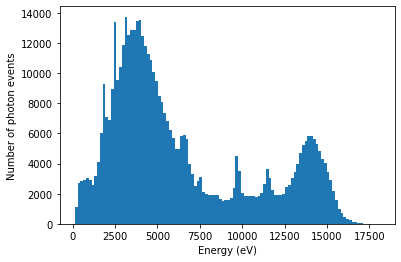

In [ ]:
energy_hist = plt.hist(evt_data['energy'], bins='auto')
plt.xlabel('Energy (eV)')
plt.ylabel('Number of photon events')

## Making a 2D histogram with some table data

Next we'll make an image by binning the x and y coordinates of the events into a 2D histogram. 

A one dimensional histogram, as shown above, shows the number of events within each bin corresponding to one axis of information. In the plot above, we chose histogram bins in the energy, shown on the x-axis.

A two dimensional histogram finds the number of events binned according to two dimensions. To make an image, we will bin the number of events by x and y position on the sky.

This particular observation spans five CCD chips.  First, we determine the events that only fell on the main (ACIS-I) chips, which have number ids 0, 1, 2, and 3. We can do this by creating an array of True and False values (`ii` below) to filter out events that only fall on those chips.

In [ ]:
ii = np.isin(evt_data['ccd_id'], [0, 1, 2, 3])

### Method 1: Use hist2d with a log-normal color scheme

We can make a 2D histogram plot directly with the function `matplotlib.pyplot.hist2d`, as shown below.

In this example, we choose the `matplotlib` color map named "viridis", and we choose to distribute the colors logarithmically using `matplotlib.colors.LogNorm()`.

To see what colormaps are available with `matplotlib`, see http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps


Text(0, 0.5, 'y')

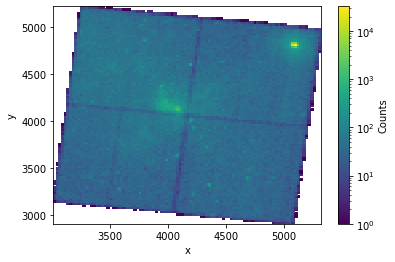

In [ ]:
NBINS = (100,100)
img_zero_mpl = plt.hist2d(evt_data['x'][ii], evt_data['y'][ii], NBINS, 
                          cmap='viridis', norm=LogNorm())

# Show the color bar scale next to the plot. The color corresponds to number 
# of photon events (counts) in each pixel.
cbar = plt.colorbar(label='Counts')

plt.xlabel('x')
plt.ylabel('y')

### Method 2: Use numpy to make a 2D histogram and imshow to display it

When we plot with `matplotlib.pyplot.hist2d`, it forces the plot into the default figure size, which could cause your image to appear stretched. 

By using `matplotlib.pyplot.imshow`, we can avoid stretching the image. To do that, we need to make a 2D array containing the number of counts per pixel bin using `numpy.histogram2d`, as shown below.

Text(0, 0.5, 'y')

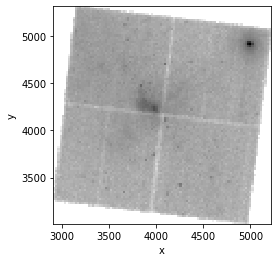

In [ ]:
NBINS = (100,100)

img_zero, xedges, yedges = np.histogram2d(evt_data['y'][ii], evt_data['x'][ii], NBINS)

# This array describes how to map the position of the 2D array containing the image
# to the x and y positions on the sky
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(img_zero, extent=extent, interpolation='nearest', 
           cmap='gist_yarg', origin='lower', norm=LogNorm())

plt.xlabel('x')
plt.ylabel('y')

## Close the FITS file

When you're done using a FITS file, it's often a good idea to close it.  That way you can be sure it won't continue using up excess memory or file handles on your computer.  (This happens automatically when you close Python, but you never know how long that might be...)

In [ ]:
hdu_list.close()

## Exercises

Make a scatter plot of the same data you histogrammed above.  The [plt.scatter](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter) function is your friend for this.  What are the pros and cons of doing it this way?

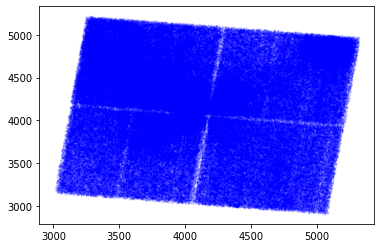

In [ ]:
energy_scatter = plt.scatter(evt_data['x'][ii], evt_data['y'][ii], s=1, alpha=0.1, color='b')

Try the same with the [plt.hexbin](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hexbin) plotting function. Which do you think looks better for this kind of data?

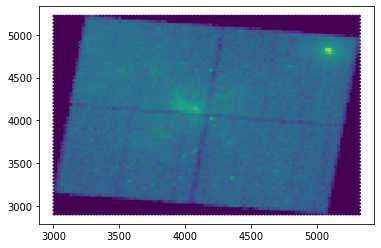

In [ ]:
energy_hex = plt.hexbin(evt_data['x'][ii], evt_data['y'][ii], norm=LogNorm())

Choose an energy range to make a slice of the FITS table, then plot it. How does the image change with different energy ranges?

Text(0, 0.5, 'y')

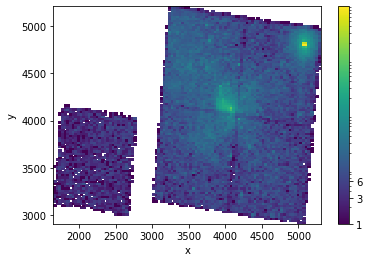

In [ ]:
NBINS = (100,100)
ii = (evt_data['energy'] > 3500) & (evt_data['energy'] < 5000)
img_zero_mpl = plt.hist2d(evt_data['x'][ii], evt_data['y'][ii], NBINS,
                          cmap='viridis', norm=LogNorm())

cbar = plt.colorbar(ticks=[1.0,3.0,6.0])
cbar.ax.set_yticklabels(['1','3','6'])

plt.xlabel('x')
plt.ylabel('y')